In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics

from torch.utils.tensorboard import SummaryWriter

import ultralytics

In [2]:
ultralytics.checks()

Ultralytics YOLOv8.0.221 🚀 Python-3.11.4 torch-2.1.1 CPU (11th Gen Intel Core(TM) i7-11700K 3.60GHz)
Setup complete ✅ (16 CPUs, 31.8 GB RAM, 552.4/930.9 GB disk)


In [48]:
all_models = torchvision.models.list_models()
classification_models = torchvision.models.list_models(module=torchvision.models)

print(all_models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2

VGG16

In [3]:
clases = ["OK", "NOK"]

In [4]:
#Split de datos en train y test
path = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\\Leather Defect Classification"
try:
    os.mkdir(path + "\\train")
    os.mkdir(path + "\\test")
    for clase in clases:
        os.mkdir(path + "\\train\\" + clase)
        os.mkdir(path + "\\test\\" + clase)
except:
    pass
for clase in clases:
    for img in os.listdir(path+"\\"+clase):
        if random.uniform(0,1) > 0.2:
            os.rename(path+"\\"+clase+"\\"+img, path + "\\train\\"+clase+"\\"+img)
        else:
            os.rename(path+"\\"+clase+"\\"+img, path + "\\test\\"+clase+"\\"+img)

In [46]:
CANTIDAD_CLASES = 2
COLOR_CHANNELS = 3
BATCH_SIZE = 16
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [6]:
trainPath = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\\Leather Defect Classification\\train"
testPath = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\\Leather Defect Classification\\test"

In [26]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root = trainPath, transform=data_transforms)
valid_set = torchvision.datasets.ImageFolder(root = testPath, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [27]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(COLOR_CHANNELS, BATCH_SIZE, BATCH_SIZE))
resnet18_model.modules

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [43]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=2)

In [41]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

Epoch: 1/30 - Train loss 0.779728 - Train Accuracy 0.437405 - Valid Loss 0.786476 - Valid Accuracy 0.402344
Epoch: 2/30 - Train loss 0.749452 - Train Accuracy 0.471023 - Valid Loss 0.766757 - Valid Accuracy 0.450781
Epoch: 3/30 - Train loss 0.742684 - Train Accuracy 0.491477 - Valid Loss 0.738364 - Valid Accuracy 0.475000
Epoch: 4/30 - Train loss 0.718529 - Train Accuracy 0.521970 - Valid Loss 0.731449 - Valid Accuracy 0.465625
Epoch: 5/30 - Train loss 0.710303 - Train Accuracy 0.533523 - Valid Loss 0.694976 - Valid Accuracy 0.532813
Epoch: 6/30 - Train loss 0.698752 - Train Accuracy 0.566761 - Valid Loss 0.690892 - Valid Accuracy 0.560938
Epoch: 7/30 - Train loss 0.692274 - Train Accuracy 0.569981 - Valid Loss 0.694984 - Valid Accuracy 0.564063
Epoch: 8/30 - Train loss 0.668453 - Train Accuracy 0.601799 - Valid Loss 0.676902 - Valid Accuracy 0.582813
Epoch: 9/30 - Train loss 0.660544 - Train Accuracy 0.611837 - Valid Loss 0.655924 - Valid Accuracy 0.607031
Epoch: 10/30 - Train loss 0.

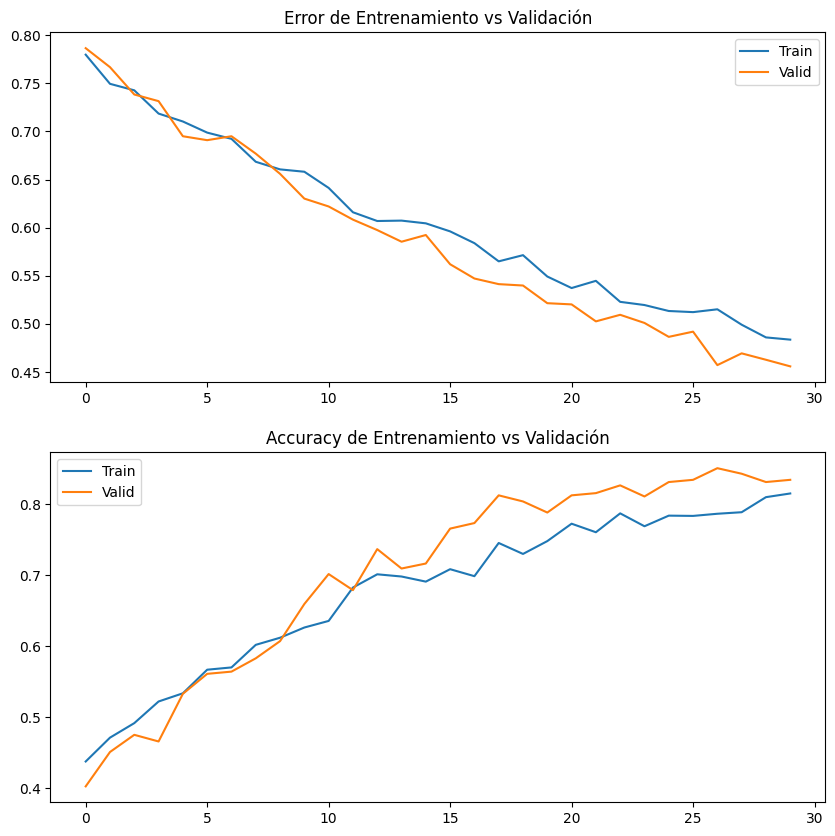

In [44]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history = train(resnet18_model.to("cpu"), 
                optimizer, 
                loss, 
                metric,
                data,
                30,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"]) 
axs[0].plot(history["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history["train_acc"]) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

VGG16

In [69]:
from torchvision.models import vgg16, VGG16_Weights

weights_vgg = VGG16_Weights.IMAGENET1K_V1
transforms_vgg = weights_vgg.transforms()

vgg16_model = vgg16(weights=weights_vgg)

if torch.cuda.is_available():
    vgg16_model.to("cuda")

torchsummary.summary(vgg16_model, input_size=(COLOR_CHANNELS, BATCH_SIZE, BATCH_SIZE))
vgg16_model.modules

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2,

In [70]:
for param in vgg16_model.parameters():
    param.requires_grad = False

last_layer_in_features_vgg = vgg16_model.classifier[-1].in_features
vgg16_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features_vgg, out_features=CANTIDAD_CLASES)

Epoch: 1/30 - Train loss 0.681649 - Train Accuracy 0.565814 - Valid Loss 0.652838 - Valid Accuracy 0.728125
Epoch: 2/30 - Train loss 0.644678 - Train Accuracy 0.667330 - Valid Loss 0.623564 - Valid Accuracy 0.842969
Epoch: 3/30 - Train loss 0.616052 - Train Accuracy 0.735038 - Valid Loss 0.601152 - Valid Accuracy 0.835156
Epoch: 4/30 - Train loss 0.593581 - Train Accuracy 0.765720 - Valid Loss 0.582560 - Valid Accuracy 0.818750
Epoch: 5/30 - Train loss 0.575789 - Train Accuracy 0.766761 - Valid Loss 0.560124 - Valid Accuracy 0.835156
Epoch: 6/30 - Train loss 0.559516 - Train Accuracy 0.791193 - Valid Loss 0.542486 - Valid Accuracy 0.843750
Epoch: 7/30 - Train loss 0.546392 - Train Accuracy 0.780398 - Valid Loss 0.532413 - Valid Accuracy 0.839063
Epoch: 8/30 - Train loss 0.530735 - Train Accuracy 0.783428 - Valid Loss 0.512874 - Valid Accuracy 0.832031
Epoch: 9/30 - Train loss 0.519342 - Train Accuracy 0.798485 - Valid Loss 0.501576 - Valid Accuracy 0.832031
Epoch: 10/30 - Train loss 0.

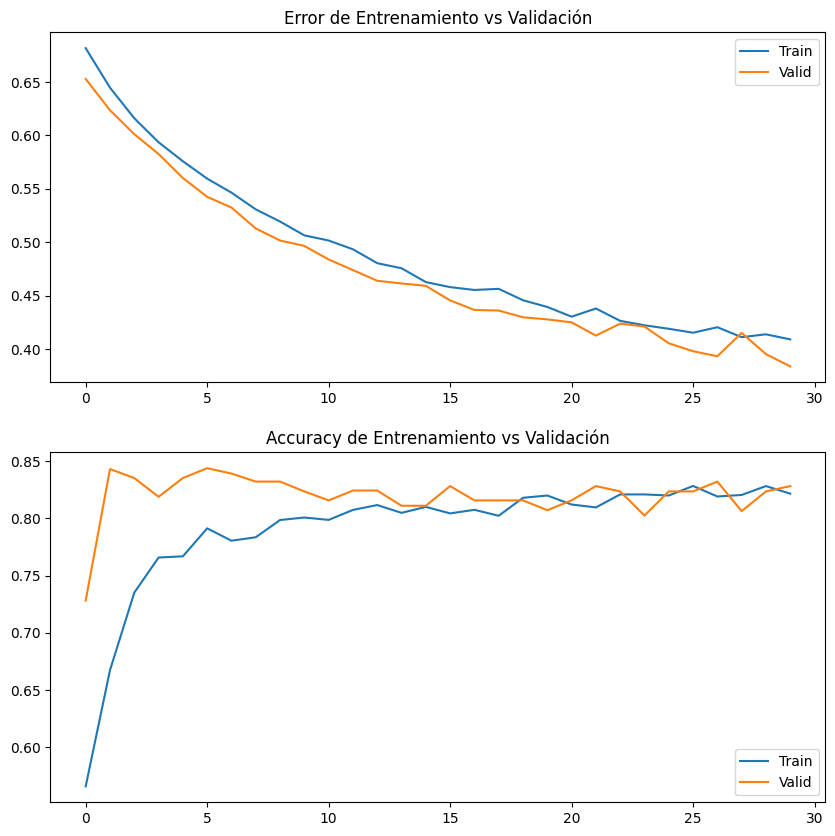

In [71]:
optimizer_vgg = torch.optim.Adam(vgg16_model.parameters(), lr=0.00001)
loss_vgg = torch.nn.CrossEntropyLoss()
metric_vgg = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data_vgg = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer_vgg = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history_vgg = train(vgg16_model.to("cpu"), 
                optimizer_vgg, 
                loss_vgg, 
                metric_vgg,
                data_vgg,
                30,
                writer_vgg)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_vgg["train_loss"]) 
axs[0].plot(history_vgg["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history_vgg["train_acc"]) 
axs[1].plot(history_vgg["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

EFFICIENTNET

In [86]:
from torchvision.models import EfficientNet_V2_L_Weights, efficientnet_v2_l

weights_effnet = EfficientNet_V2_L_Weights.IMAGENET1K_V1
transforms_effnet = weights_effnet.transforms()

effnet_model = efficientnet_v2_l(weights=weights_effnet)

if torch.cuda.is_available():
    effnet_model.to("cuda")

torchsummary.summary(effnet_model, input_size=(COLOR_CHANNELS, BATCH_SIZE, BATCH_SIZE))
effnet_model.modules

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to C:\Users\Alejandro/.cache\torch\hub\checkpoints\efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:14<00:00, 32.3MB/s] 


Layer (type:depth-idx)                        Param #
├─Sequential: 1-1                             --
|    └─Conv2dNormActivation: 2-1              --
|    |    └─Conv2d: 3-1                       864
|    |    └─BatchNorm2d: 3-2                  64
|    |    └─SiLU: 3-3                         --
|    └─Sequential: 2-2                        --
|    |    └─FusedMBConv: 3-4                  9,280
|    |    └─FusedMBConv: 3-5                  9,280
|    |    └─FusedMBConv: 3-6                  9,280
|    |    └─FusedMBConv: 3-7                  9,280
|    └─Sequential: 2-3                        --
|    |    └─FusedMBConv: 3-8                  45,440
|    |    └─FusedMBConv: 3-9                  164,480
|    |    └─FusedMBConv: 3-10                 164,480
|    |    └─FusedMBConv: 3-11                 164,480
|    |    └─FusedMBConv: 3-12                 164,480
|    |    └─FusedMBConv: 3-13                 164,480
|    |    └─FusedMBConv: 3-14                 164,480
|    └─Sequential

<bound method Module.modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=Tr

In [87]:
for param in effnet_model.parameters():
    param.requires_grad = False

last_layer_in_features_effnet = effnet_model.classifier[-1].in_features
effnet_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features_effnet, out_features=CANTIDAD_CLASES)

Epoch: 1/30 - Train loss 0.714318 - Train Accuracy 0.564773 - Valid Loss 0.739459 - Valid Accuracy 0.610938
Epoch: 2/30 - Train loss 0.707588 - Train Accuracy 0.558996 - Valid Loss 0.720470 - Valid Accuracy 0.610938
Epoch: 3/30 - Train loss 0.679453 - Train Accuracy 0.604924 - Valid Loss 0.881710 - Valid Accuracy 0.689844
Epoch: 4/30 - Train loss 0.676854 - Train Accuracy 0.592519 - Valid Loss 0.651226 - Valid Accuracy 0.686719
Epoch: 5/30 - Train loss 0.651716 - Train Accuracy 0.629356 - Valid Loss 1.225052 - Valid Accuracy 0.721875
Epoch: 6/30 - Train loss 0.643303 - Train Accuracy 0.624148 - Valid Loss 0.607336 - Valid Accuracy 0.699219
Epoch: 7/30 - Train loss 0.647970 - Train Accuracy 0.622159 - Valid Loss 0.787527 - Valid Accuracy 0.737500
Epoch: 8/30 - Train loss 0.617211 - Train Accuracy 0.658902 - Valid Loss 0.602355 - Valid Accuracy 0.792188
Epoch: 9/30 - Train loss 0.613616 - Train Accuracy 0.674621 - Valid Loss 0.947438 - Valid Accuracy 0.796875
Epoch: 10/30 - Train loss 0.

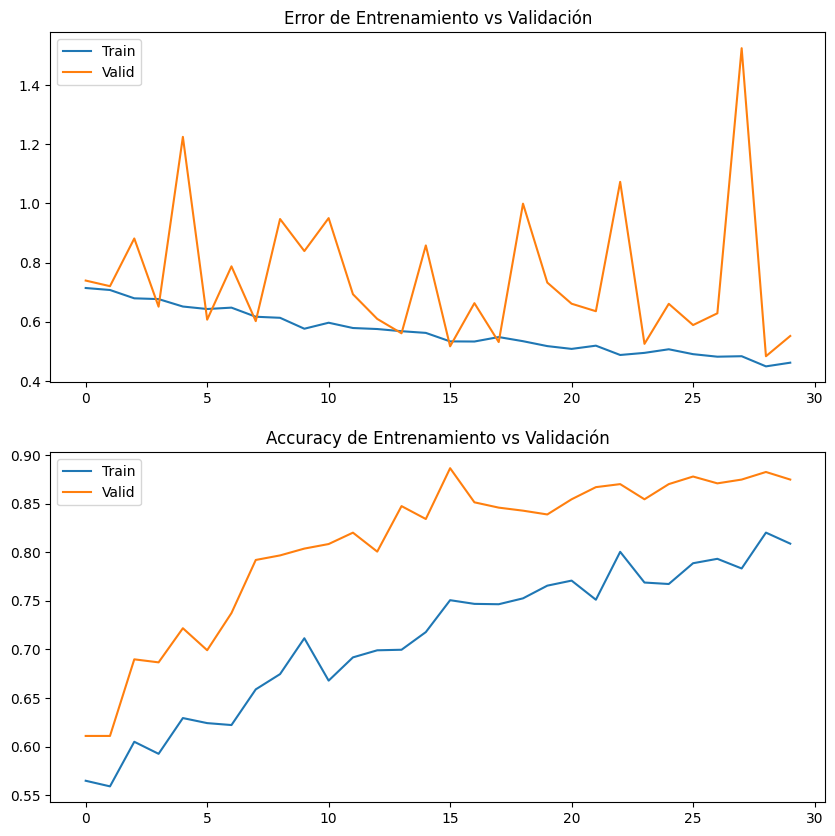

In [88]:
optimizer_effnet = torch.optim.Adam(effnet_model.parameters(), lr=0.00001)
loss_effnet = torch.nn.CrossEntropyLoss()
metric_effnet = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data_effnet = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer_effnet = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history_effnet = train(effnet_model.to("cpu"), 
                optimizer_effnet, 
                loss_effnet, 
                metric_effnet,
                data_effnet,
                30,
                writer_effnet)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_effnet["train_loss"]) 
axs[0].plot(history_effnet["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history_effnet["train_acc"]) 
axs[1].plot(history_effnet["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

REGNET

In [91]:
from torchvision.models import RegNet_Y_128GF_Weights, regnet_y_128gf

weights_regnet = RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_E2E_V1
transforms_regnet = weights_regnet.transforms()

regnet_model = regnet_y_128gf(weights=weights_regnet)

if torch.cuda.is_available():
    regnet_model.to("cuda")

torchsummary.summary(regnet_model, input_size=(COLOR_CHANNELS, BATCH_SIZE, BATCH_SIZE))
regnet_model.modules

Layer (type:depth-idx)                             Param #
├─SimpleStemIN: 1-1                                --
|    └─Conv2d: 2-1                                 864
|    └─BatchNorm2d: 2-2                            64
|    └─ReLU: 2-3                                   --
├─Sequential: 1-2                                  --
|    └─AnyStage: 2-4                               --
|    |    └─ResBottleneckBlock: 3-1                1,580,312
|    |    └─ResBottleneckBlock: 3-2                1,955,316
|    └─AnyStage: 2-5                               --
|    |    └─ResBottleneckBlock: 3-3                5,027,748
|    |    └─ResBottleneckBlock: 3-4                5,304,552
|    |    └─ResBottleneckBlock: 3-5                5,304,552
|    |    └─ResBottleneckBlock: 3-6                5,304,552
|    |    └─ResBottleneckBlock: 3-7                5,304,552
|    |    └─ResBottleneckBlock: 3-8                5,304,552
|    |    └─ResBottleneckBlock: 3-9                5,304,552
|    └─AnySta

<bound method Module.modules of RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

In [95]:
for param in regnet_model.parameters():
    param.requires_grad = False

last_layer_in_features_regnet = regnet_model.fc.in_features
regnet_model.fc = torch.nn.Linear(in_features=last_layer_in_features_regnet, out_features=CANTIDAD_CLASES)

Epoch: 1/10 - Train loss 0.591867 - Train Accuracy 0.689678 - Valid Loss 0.566136 - Valid Accuracy 0.742188
Epoch: 2/10 - Train loss 0.527535 - Train Accuracy 0.765341 - Valid Loss 0.803735 - Valid Accuracy 0.796875
Epoch: 3/10 - Train loss 0.486477 - Train Accuracy 0.798485 - Valid Loss 0.455250 - Valid Accuracy 0.859375
Epoch: 4/10 - Train loss 0.455373 - Train Accuracy 0.834943 - Valid Loss 0.532643 - Valid Accuracy 0.820312
Epoch: 5/10 - Train loss 0.418537 - Train Accuracy 0.835417 - Valid Loss 0.434748 - Valid Accuracy 0.795313
Epoch: 6/10 - Train loss 0.400300 - Train Accuracy 0.863542 - Valid Loss 0.991991 - Valid Accuracy 0.783594
Epoch: 7/10 - Train loss 0.377341 - Train Accuracy 0.854261 - Valid Loss 0.375243 - Valid Accuracy 0.874219
Epoch: 8/10 - Train loss 0.375321 - Train Accuracy 0.863068 - Valid Loss 0.351458 - Valid Accuracy 0.901563
Epoch: 9/10 - Train loss 0.343858 - Train Accuracy 0.873958 - Valid Loss 0.358465 - Valid Accuracy 0.898438
Epoch: 10/10 - Train loss 0.

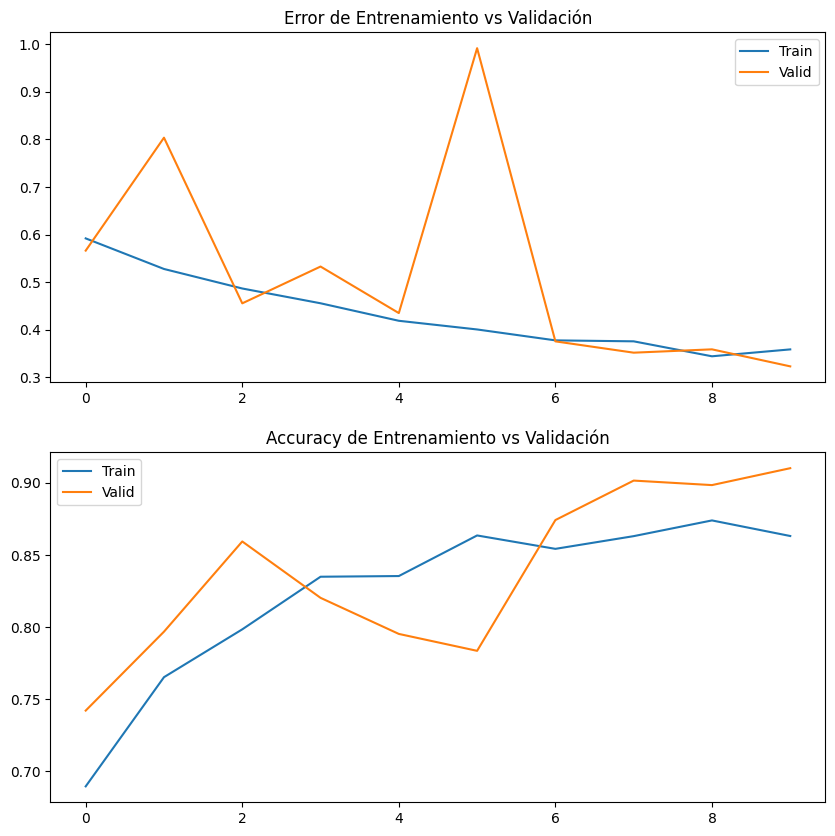

In [97]:
optimizer_regnet = torch.optim.Adam(regnet_model.parameters(), lr=0.00001)
loss_regnet = torch.nn.CrossEntropyLoss()
metric_regnet = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data_regnet = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer_regnet = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history_regnet = train(regnet_model.to("cpu"), 
                optimizer_regnet, 
                loss_regnet, 
                metric_regnet,
                data_regnet,
                10,
                writer_regnet)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_regnet["train_loss"]) 
axs[0].plot(history_regnet["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history_regnet["train_acc"]) 
axs[1].plot(history_regnet["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

SWIN

In [98]:
from torchvision.models import Swin_V2_B_Weights, swin_v2_b

weights_swin = Swin_V2_B_Weights.IMAGENET1K_V1
transforms_swin = weights_swin.transforms()

swin_model = swin_v2_b(weights=weights_swin)

if torch.cuda.is_available():
    swin_model.to("cuda")

torchsummary.summary(swin_model, input_size=(COLOR_CHANNELS, BATCH_SIZE, BATCH_SIZE))
swin_model.modules

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to C:\Users\Alejandro/.cache\torch\hub\checkpoints\swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:18<00:00, 19.0MB/s] 


Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Sequential: 2-1                                  --
|    |    └─Conv2d: 3-1                                 6,272
|    |    └─Permute: 3-2                                --
|    |    └─LayerNorm: 3-3                              256
|    └─Sequential: 2-2                                  --
|    |    └─SwinTransformerBlockV2: 3-4                 201,860
|    |    └─SwinTransformerBlockV2: 3-5                 201,860
|    └─PatchMergingV2: 2-3                              --
|    |    └─Linear: 3-6                                 131,072
|    |    └─LayerNorm: 3-7                              512
|    └─Sequential: 2-4                                  --
|    |    └─SwinTransformerBlockV2: 3-8                 795,400
|    |    └─SwinTransformerBlockV2: 3-9                 795,400
|    └─PatchMergingV2: 2-5                              --
|    |    └─Linear: 3

<bound method Module.modules of SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias

In [102]:
for param in swin_model.parameters():
    param.requires_grad = False

last_layer_in_features_swin = swin_model.head.in_features
swin_model.head = torch.nn.Linear(in_features=last_layer_in_features_swin, out_features=CANTIDAD_CLASES)

Epoch: 1/30 - Train loss 0.673874 - Train Accuracy 0.635038 - Valid Loss 0.649891 - Valid Accuracy 0.722656
Epoch: 2/30 - Train loss 0.659797 - Train Accuracy 0.689205 - Valid Loss 0.635316 - Valid Accuracy 0.804688
Epoch: 3/30 - Train loss 0.646988 - Train Accuracy 0.736742 - Valid Loss 0.621291 - Valid Accuracy 0.846875
Epoch: 4/30 - Train loss 0.636051 - Train Accuracy 0.755303 - Valid Loss 0.608727 - Valid Accuracy 0.862500
Epoch: 5/30 - Train loss 0.623436 - Train Accuracy 0.781818 - Valid Loss 0.592759 - Valid Accuracy 0.886719
Epoch: 6/30 - Train loss 0.612038 - Train Accuracy 0.797443 - Valid Loss 0.581244 - Valid Accuracy 0.898438
Epoch: 7/30 - Train loss 0.598233 - Train Accuracy 0.819318 - Valid Loss 0.573319 - Valid Accuracy 0.885156
Epoch: 8/30 - Train loss 0.595848 - Train Accuracy 0.806250 - Valid Loss 0.557781 - Valid Accuracy 0.906250
Epoch: 9/30 - Train loss 0.587145 - Train Accuracy 0.811648 - Valid Loss 0.547322 - Valid Accuracy 0.906250
Epoch: 10/30 - Train loss 0.

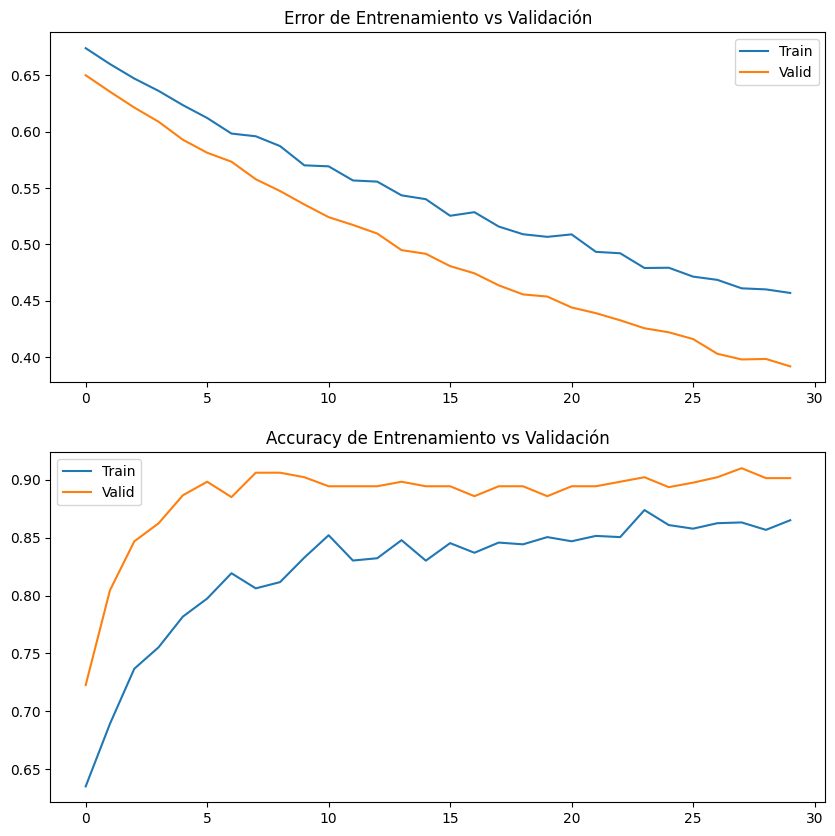

In [103]:
optimizer_swin = torch.optim.Adam(swin_model.parameters(), lr=0.00001)
loss_swin = torch.nn.CrossEntropyLoss()
metric_swin = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data_swin = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer_swin = {"train": SummaryWriter(log_dir="transfer_learning/train"),
          "valid": SummaryWriter(log_dir="transfer_learning/valid")}

history_swin = train(swin_model.to("cpu"), 
                optimizer_swin, 
                loss_swin, 
                metric_swin,
                data_swin,
                30,
                writer_swin)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history_swin["train_loss"]) 
axs[0].plot(history_swin["valid_loss"]) 
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])  

axs[1].plot(history_swin["train_acc"]) 
axs[1].plot(history_swin["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

YOLO

In [51]:
# import YOLO model
from ultralytics import YOLO

In [75]:
#path = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\\Leather Defect Classification"
path = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\\datasets\\leather"

In [76]:
# Load a model
model = YOLO('yolov8n-cls.pt') # load a pretrained model (recommended for training)

# Train the model
model.train(data=path, epochs=5)

New https://pypi.org/project/ultralytics/8.0.225 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.221 🚀 Python-3.11.4 torch-2.1.1 CPU (11th Gen Intel Core(TM) i7-11700K 3.60GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather, epochs=5, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=Fa

train: Scanning C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\train... 955 images, 0 corrupt: 100%|██████████| 955/955 [00:01<00:00, 920.72it/s]

train: New cache created: C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\train.cache



val: Scanning C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\test... 245 images, 0 corrupt: 100%|██████████| 245/245 [00:00<00:00, 998.60it/s]

val: New cache created: C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\test.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to runs\classify\train7
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all      0.992          1



5 epochs completed in 0.037 hours.
Optimizer stripped from runs\classify\train7\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train7\weights\best.pt, 3.0MB

Validating runs\classify\train7\weights\best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.11.4 torch-2.1.1 CPU (11th Gen Intel Core(TM) i7-11700K 3.60GHz)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\train... found 955 images in 2 classes ✅ 
val: None...
test: C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\datasets\leather\test... found 245 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


                   all      0.992          1
Speed: 0.0ms preprocess, 6.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train7
Results saved to runs\classify\train7


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000182516E58D0>
curves: []
curves_results: []
fitness: 0.9959183633327484
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9918367266654968, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9959183633327484}
save_dir: WindowsPath('runs/classify/train7')
speed: {'preprocess': 0.0, 'inference': 6.13458691811075, 'loss': 0.0, 'postprocess': 0.0}
task: 'classify'
top1: 0.9918367266654968
top5: 1.0

In [85]:
model = YOLO("runs/classify/train7/weights/best.pt")
#filePath = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\Leather Defect Classification\\test\\NOK\\Growth mark01 (1).jpg"
filePath = "C:\\Users\\Alejandro\\Desktop\\MIA Trabajo final\\Repositorio\\SFVI-MIA\\GUI\\PyQt Designer\\tests\Leather Defect Classification\\test\\OK\\Non defective 01 (6).jpg"
results = model(filePath)[0]
results = results.probs
print(results.data)
#print("Maximum probability: ",max(results))
#print("Class with maximum probability: ",results.index(max(results))+1)


image 1/1 C:\Users\Alejandro\Desktop\MIA Trabajo final\Repositorio\SFVI-MIA\GUI\PyQt Designer\tests\Leather Defect Classification\test\OK\Non defective 01 (6).jpg: 224x224 OK 1.00, NOK 0.00, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
tensor([7.1127e-06, 9.9999e-01])
